# Time Series Prediction with Convolutional Neural Networks ($CNN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-07 18:54:10

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Gathering Dependencies

_Importing Required Libraries_

In [2]:
pip install hampel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import array

## Loading Datasets

_Bjørnøya_

In [4]:
data = pd.read_csv("/content/drive/MyDrive/new/datasets/Rainfall.csv", sep = ";")
training_set = data.set_index("Time(norwegian mean time)")
training_set = training_set.iloc[:,2]

## Preprocessing the Data

In [5]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

Streaming output truncated to the last 5000 lines.
[0.4 0.6 0.2] 4.5
[0.6 0.2 4.5] 0.4
[0.2 4.5 0.4] 0.6
[4.5 0.4 0.6] 1.5
[0.4 0.6 1.5] 4.1
[0.6 1.5 4.1] 2.2
[1.5 4.1 2.2] 1.0
[4.1 2.2 1. ] 0.6
[2.2 1.  0.6] 0.8
[1.  0.6 0.8] 0.6
[0.6 0.8 0.6] 4.5
[0.8 0.6 4.5] 0.2
[0.6 4.5 0.2] 0.0
[4.5 0.2 0. ] 0.0
[0.2 0.  0. ] 0.8
[0.  0.  0.8] 0.4
[0.  0.8 0.4] 0.0
[0.8 0.4 0. ] 0.2
[0.4 0.  0.2] 0.0
[0.  0.2 0. ] 0.0
[0.2 0.  0. ] 0.2
[0.  0.  0.2] 0.0
[0.  0.2 0. ] 0.0
[0.2 0.  0. ] 0.0
[0. 0. 0.] 0.4
[0.  0.  0.4] 1.4
[0.  0.4 1.4] 0.0
[0.4 1.4 0. ] 0.0
[1.4 0.  0. ] 0.0
[0. 0. 0.] 0.0
[0. 0. 0.] 0.0
[0. 0. 0.] 0.0
[0. 0. 0.] 0.0
[0. 0. 0.] 0.9
[0.  0.  0.9] 0.6
[0.  0.9 0.6] 0.0
[0.9 0.6 0. ] 0.2
[0.6 0.  0.2] 0.0
[0.  0.2 0. ] 8.0
[0.2 0.  8. ] 0.2
[0.  8.  0.2] 0.0
[8.  0.2 0. ] 0.0
[0.2 0.  0. ] 0.8
[0.  0.  0.8] 0.0
[0.  0.8 0. ] 0.4
[0.8 0.  0.4] 2.0
[0.  0.4 2. ] 3.3
[0.4 2.  3.3] 0.6
[2.  3.3 0.6] 0.0
[3.3 0.6 0. ] 0.2
[0.6 0.  0.2] 0.0
[0.  0.2 0. ] 0.8
[0.2 0.  0.8] 1.0
[0.  0.8 1. ]

## Train and Test Split

In [6]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(12253, 1, 3) (12253,) (3064, 1, 3) (3064,)


## Model ($CNN$)

In [7]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), verbose=1, shuffle=False)

Epoch 1/500
192/192 [==============================] - 3s 5ms/step - loss: 6.0604 - val_loss: 6.7990
Epoch 2/500
192/192 [==============================] - 1s 5ms/step - loss: 5.6422 - val_loss: 6.7652
Epoch 3/500
192/192 [==============================] - 2s 10ms/step - loss: 5.6351 - val_loss: 6.7655
Epoch 4/500
192/192 [==============================] - 2s 9ms/step - loss: 5.6347 - val_loss: 6.7670
Epoch 5/500
192/192 [==============================] - 1s 7ms/step - loss: 5.6344 - val_loss: 6.7682
Epoch 6/500
192/192 [==============================] - 1s 3ms/step - loss: 5.6341 - val_loss: 6.7694
Epoch 7/500
192/192 [==============================] - 1s 3ms/step - loss: 5.6338 - val_loss: 6.7703
Epoch 8/500
192/192 [==============================] - 1s 3ms/step - loss: 5.6336 - val_loss: 6.7711
Epoch 9/500
192/192 [==============================] - 1s 3ms/step - loss: 5.6333 - val_loss: 6.7718
Epoch 10/500
192/192 [==============================] - 1s 3ms/step - loss: 5.6331 - val_l

## Metrics ($CNN$)

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX, verbose=0)
rmse = np.sqrt(mean_squared_error(testY, yhat))
mae = np.sqrt(mean_absolute_error(testY, yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 2.601
Test MAE: 1.205


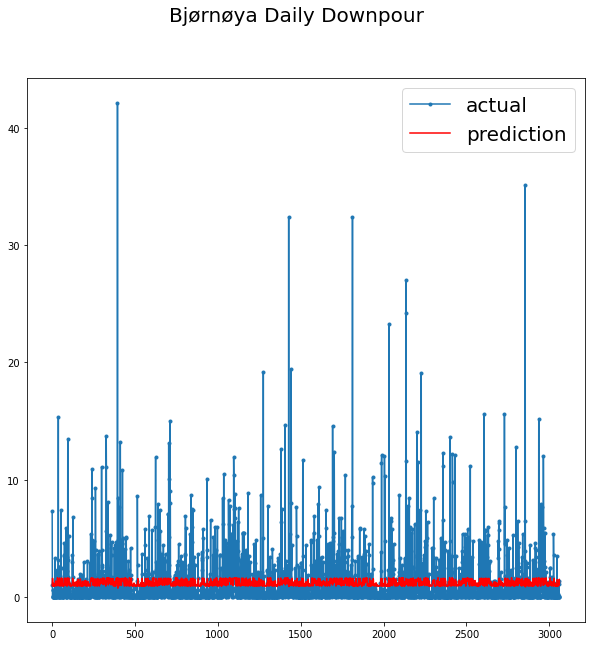

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
anurag=[x for x in range(3062)]
plt.plot(anurag, testY[:3062], marker='.', label="actual")
plt.plot(anurag, yhat[:3062], 'r', label="prediction")
plt.suptitle('Bjørnøya Daily Downpour', fontsize=20)
plt.legend(fontsize=20)
plt.show()